## Banking Churn Modelling

In this example notebook, we will explore how we can use each tree boosting algorithm and how we can interpret the model using various techniques (i.e. `shap` and `lime`).

In [1]:
import pandas as pd
import numpy as np
import os, sys
pd.set_option('display.max_colwidth', 1000)
import warnings

warnings.filterwarnings("ignore")
# ML
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
# Viz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")

from IPython.display import display, HTML
# plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected = True)

# model interpretation
import shap
import lime
shap.initjs()  # essential for visualization

In [2]:
SEED = 4895
PATH = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()
os.chdir(PATH)
np.random.seed(SEED)

def missing_values_table(df):
    """
     Function to explore how many missing values (NaN) in the dataframe against its size
     @Args:
       df: the input dataframe for analysis
     
     Return:
       mis_val_table_ren_columns: dataframe table contains the name of columns with missing data, # of missing values and % of missing against total
    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print("There are %s columns that have missing values.\n" % (mis_val_table_ren_columns.shape[0]))
    if mis_val_table_ren_columns.shape[0] > 0:
        print(mis_val_table_ren_columns.head(5))
        
    return mis_val_table_ren_columns

In [3]:
def read_data(path:str='../data/'):
    df = pd.read_csv(path)
    df.columns = map(str.lower, df.columns)
    print(df.shape)
    display(df.head(3))
    _ = missing_values_table(df)
    return df


df = read_data('../data/Churn_Modelling.csv')

(10000, 14)


rownumber  customerid   surname  creditscore geography  gender  age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   

   tenure    balance  numofproducts  hascrcard  isactivemember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   

   estimatedsalary  exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1

There are 0 columns that have missing values.



### Plot the target distribution

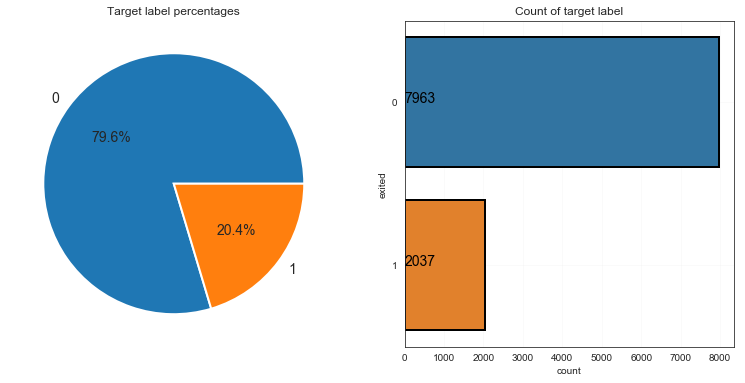

In [4]:
def visual_target_distribution(df:pd.DataFrame, targetColName:str):
    """Function to plot the target distribution"""
    plt.figure(figsize=(13,6))
    plt.subplot(121)
    df[targetColName]\
        .value_counts()\
        .plot\
        .pie(autopct="%1.1f%%", fontsize=14,\
             wedgeprops={"linewidth": 2, "edgecolor": "w"})
    plt.title("Target label percentages")
    plt.ylabel("")
    plt.subplot(122)
    ax = sns.countplot(y=df[targetColName], linewidth=2, 
                       edgecolor = "k"*df[targetColName].nunique())
    for i, j in enumerate(df[targetColName].value_counts().values) : 
        ax.text(.1, i, j, fontsize=14, color="k")

    plt.title("Count of target label")
    plt.grid(True, alpha = .1)
    plt.show()
    return 


idxCol, targetCol = 'customerid', 'exited'
visual_target_distribution(df, targetCol)

### Feature transformation

- feature understanding
- drop unnecessary column
- create one-hot encoding on categorical features

In [5]:
# rownumber is not useful
df.drop('rownumber', axis=1, inplace=True)

Processing column name: "surname"
	Too many unique values to plot
	Print number of unique values instead: 2932


Processing column name: "creditscore"


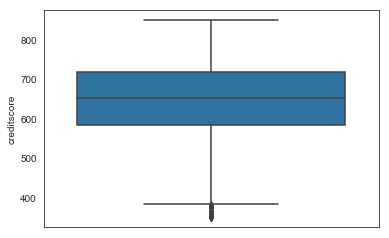



Processing column name: "geography"


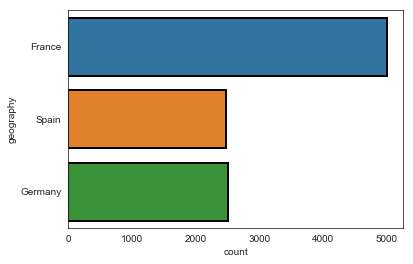



Processing column name: "gender"


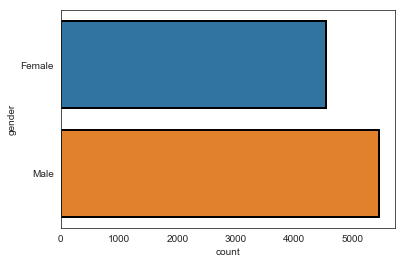



Processing column name: "age"


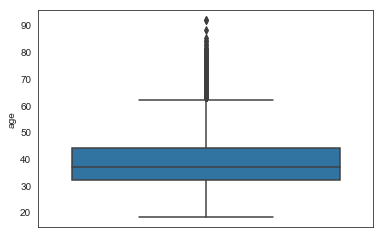



Processing column name: "tenure"


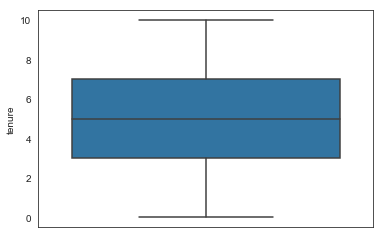



Processing column name: "balance"


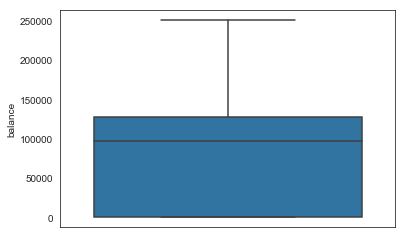



Processing column name: "numofproducts"


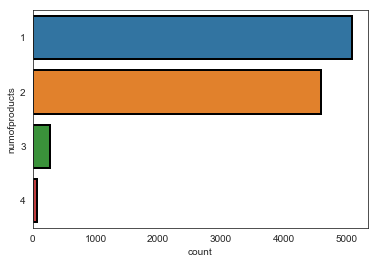



Processing column name: "hascrcard"


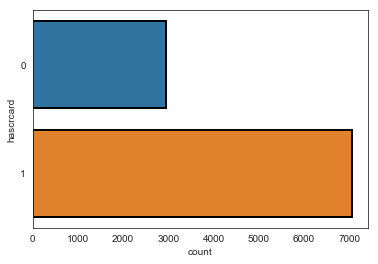



Processing column name: "isactivemember"


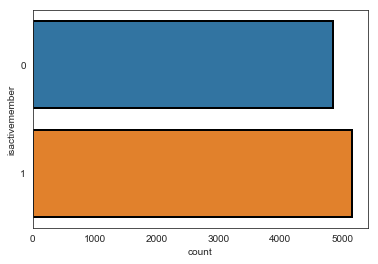



Processing column name: "estimatedsalary"


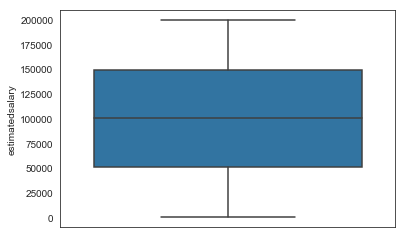

In [6]:
cols = [i for i in df.columns if (i not in [idxCol, targetCol])]
for col in cols:
    print('Processing column name: "{}"'.format(col))
    if df[col].dtypes == 'object':
        if df[col].nunique() >= 10:
            print('\tToo many unique values to plot')
            print('\tPrint number of unique values instead: {}'.format(df[col].nunique()))
            
        else:
            ax = sns.countplot(y=df[col], linewidth=2, 
                               edgecolor = "k"*df[col].nunique())
            plt.show()
            
    elif df[col].dtypes == 'int64':
        if df[col].nunique() >= 5:
            ax = sns.boxplot(x=df[col], orient='v', linewidth=1.5)
            plt.show()
            
        else:
            ax = sns.countplot(y=df[col], linewidth=2, 
                               edgecolor = "k"*df[col].nunique())
            plt.show()

    else:
        ax = sns.boxplot(x=df[col], orient='v', linewidth=1.5)
        plt.show()
        
    print('\n')

In [7]:
df.groupby('surname').customerid.nunique().sort_values(ascending=False).head(10)

surname
Smith       32
Martin      29
Scott       29
Walker      28
Brown       26
Shih        25
Genovese    25
Yeh         25
Maclean     24
Wright      24
Name: customerid, dtype: int64

In [8]:
df.head()

customerid   surname  creditscore geography  gender  age  tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     balance  numofproducts  hascrcard  isactivemember  estimatedsalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   exited  
0       1  
1       0  
2       1  
3       0  
4       0

Different people may share similar `surname` but are not related. Hence, we will remove this column due to this reason

In [9]:
df.drop('surname', axis=1, inplace=True)

In [10]:
transformed_df = pd.concat([
    df, pd.get_dummies(df['geography'], prefix='country'), pd.get_dummies(df['gender'], prefix='gender')
], axis=1)

In [11]:
transformed_df.drop(['geography', 'gender', 'gender_Male', 'country_Spain'], axis=1, inplace=True)
transformed_df.head(2)

customerid  creditscore  age  tenure   balance  numofproducts  hascrcard  \
0    15634602          619   42       2      0.00              1          1   
1    15647311          608   41       1  83807.86              1          0   

   isactivemember  estimatedsalary  exited  country_France  country_Germany  \
0               1        101348.88       1               1                0   
1               1        112542.58       0               0                0   

   gender_Female  
0              1  
1              1

## Model building

- In this notebook, we will test out several tree-based algorithms (random forest, xgboost, lightgbm, and catboost)
- Please note, we are focusing on explainability and interpretability. The model will not be tuned.

In [12]:
id_col = 'customerid'
target_col = 'exited'

In [13]:
def generate_train_test(df:pd.DataFrame, 
                        test_size:float=0.2):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=SEED)
    cols = [i for i in df.columns if i not in id_col + target_col]
    X_train = train_df[cols]
    X_test = test_df[cols]
    y_train = train_df[target_col]
    y_test = test_df[target_col]
    return X_train, y_train, X_test, y_test



In [14]:
def generate_feature_important_matrix(model, X_train:pd.DataFrame):
    col_df = pd.DataFrame(X_train.columns)
    coeff = pd.DataFrame(model.feature_importances_)
    df = pd.merge(col_df, coeff, left_index=True, right_index=True, how='right')
    df.columns = ['features', 'coefficients']
    df.sort_values(by='coefficients', ascending=False, inplace=True)
    return df

In [15]:
def print_model_evaluation(model, y_true, y_pred, y_prob):
    print("\nClassification report: \n", classification_report(y_true, y_pred))
    print("\nAccuracy Score: ", np.round(accuracy_score(y_true, y_pred), 4))
    print("F1 Score: ", np.round(f1_score(y_true, y_pred), 4))
    print("Area Under Curve: ", np.round(roc_auc_score(y_true, y_prob[:, 1]), 4), "\n")
    return 


def plot_model_evaluation(model, y_true, y_pred, y_prob,
                          X_train:pd.DataFrame,
                          figsize:tuple=(14, 18)):
    fig = plt.figure(figsize=figsize)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.subplot(321)
    plt.plot(fpr, tpr, color='red', lw=1, alpha=.8,
             label='{}'.format(str(model).split('(', 1)[0]))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend()
    plt.title("ROC Curve of the model ({:.2f})"\
                  .format(np.round(roc_auc_score(y_true, y_prob[:, 1]), 4)),
              fontdict={'size': 16})
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.subplot(322)
    lr_precision, lr_recall, _ = precision_recall_curve(y_true,  y_prob[:, 1])
    exit = len(y_true[y_true==1]) / len(y_true)
    plt.plot([0, 1], [exit, exit], linestyle='--', 
             color='navy', alpha=.6, label='{} (random)'.format(target_col))
    plt.plot(lr_recall, lr_precision, lw=1, alpha=.8,
             color='red', label='{}'.format(str(model).split('(', 1)[0]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('F1 score: {:.2f}'.format(f1_score(y_true, y_pred)),
              fontdict={'size': 16})
    plt.legend()

    plt.subplot(312)
    smry_df = generate_feature_important_matrix(model, X_train)
    ax = sns.barplot(y="coefficients", x="features", data=smry_df, color="red", alpha=.3)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x()+p.get_width()/2., 
                    p.get_height()), 
                    ha='center', va='center', xytext=(0, 3), 
                    textcoords='offset points')

    plt.xticks(rotation=30)
    plt.xlabel('Features', fontdict={'size': 14})
    plt.yticks([])
    plt.ylabel(None)
    plt.title("Feature Importances",
              fontdict={'size': 16})
    
    plt.subplot(313)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%% \n %d / %d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
                
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.heatmap(cm, cmap= "RdYlGn", annot=annot, 
                fmt='', alpha=.7, cbar=False)
    
    plt.subplots_adjust(hspace=.5)
    plt.suptitle("Performance Report of {}".format(str(model).split('(', 1)[0]), 
                 size=24)
    plt.show()
    return



Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.91      1960
           1       0.79      0.46      0.58       540

   micro avg       0.86      0.86      0.86      2500
   macro avg       0.83      0.71      0.75      2500
weighted avg       0.85      0.86      0.84      2500


Accuracy Score:  0.8572
F1 Score:  0.5805
Area Under Curve:  0.8638 



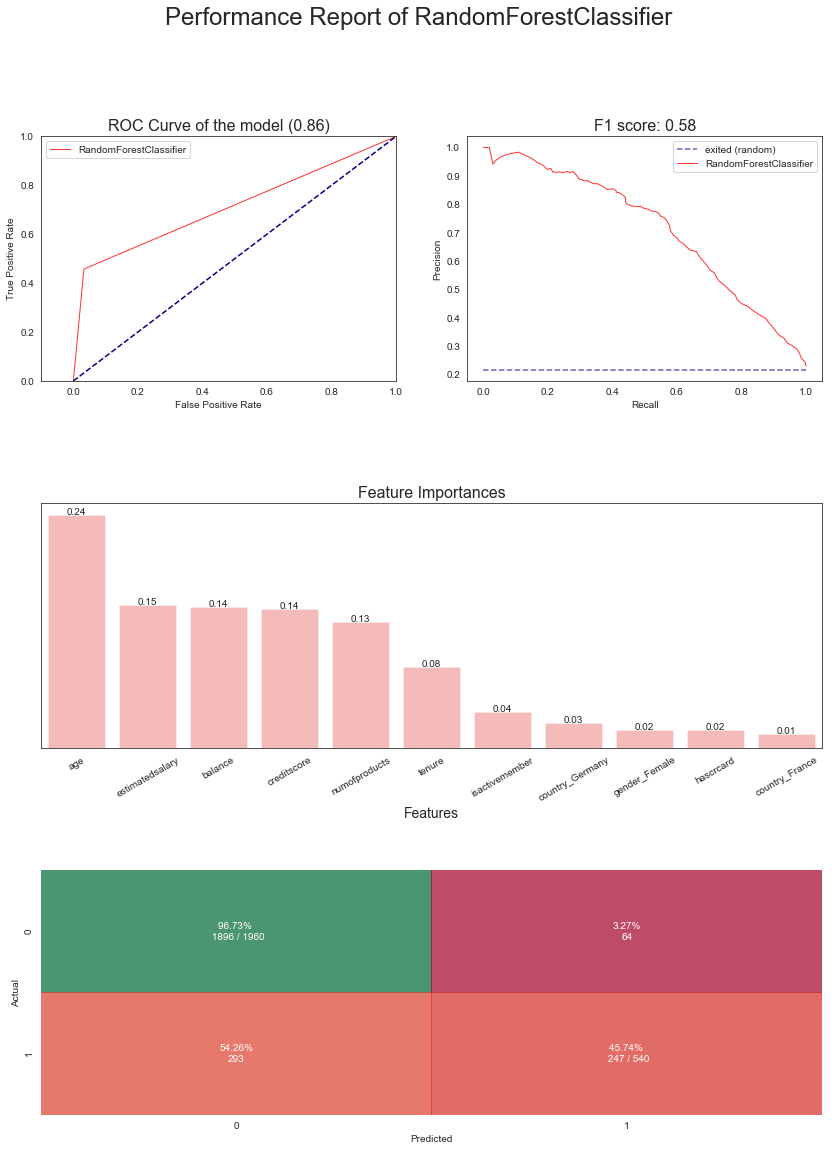

In [16]:
X_train, y_train, X_test, y_test = generate_train_test(transformed_df, test_size=.25)
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)
print_model_evaluation(model=rf_model, y_true=y_test, y_pred=y_pred, y_prob=y_prob)
plot_model_evaluation(rf_model, y_test, y_pred, y_prob, X_train)


Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1960
           1       0.80      0.47      0.59       540

   micro avg       0.86      0.86      0.86      2500
   macro avg       0.84      0.72      0.75      2500
weighted avg       0.85      0.86      0.85      2500


Accuracy Score:  0.86
F1 Score:  0.5902
Area Under Curve:  0.8713 



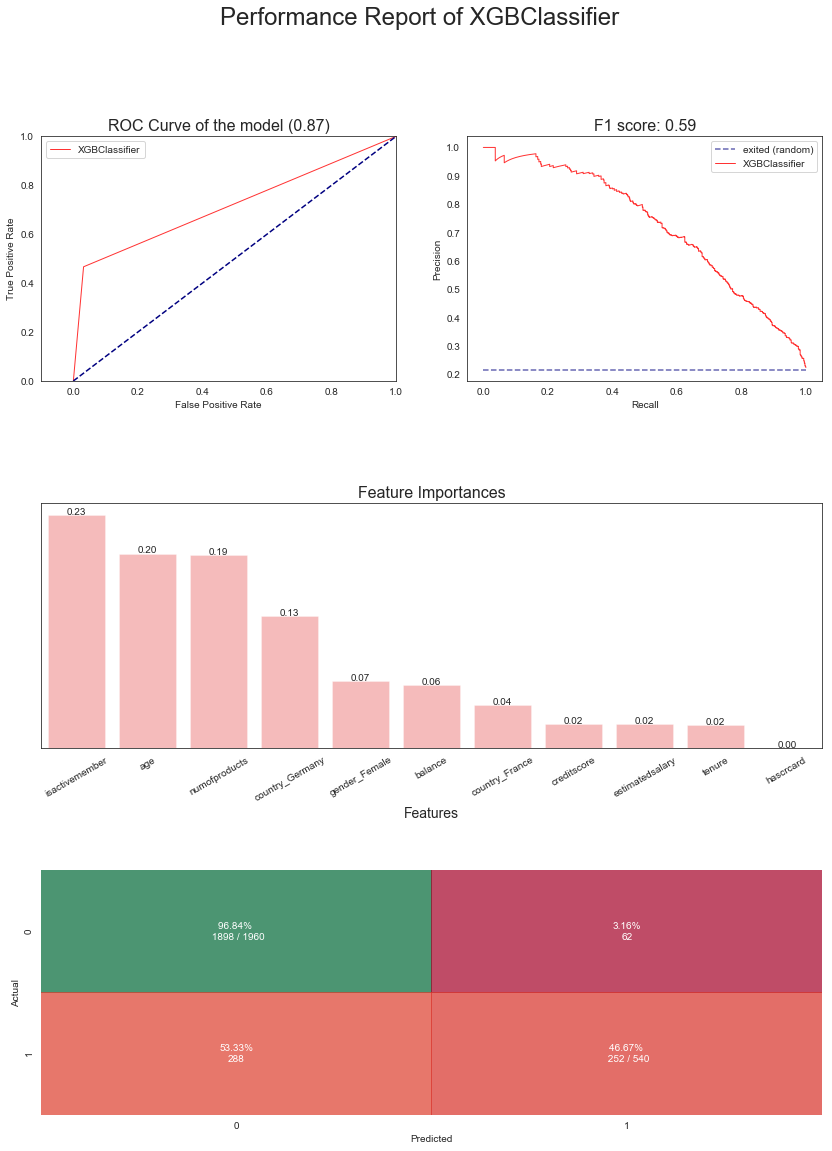

In [17]:
X_train, y_train, X_test, y_test = generate_train_test(transformed_df, test_size=.25)
xgb_model = xgb.XGBClassifier(random_state=SEED)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)
print_model_evaluation(model=xgb_model, y_true=y_test, y_pred=y_pred, y_prob=y_prob)
plot_model_evaluation(xgb_model, y_test, y_pred, y_prob, X_train)


Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      1960
           1       0.82      0.50      0.62       540

   micro avg       0.87      0.87      0.87      2500
   macro avg       0.85      0.73      0.77      2500
weighted avg       0.86      0.87      0.86      2500


Accuracy Score:  0.868
F1 Score:  0.6207
Area Under Curve:  0.8772 



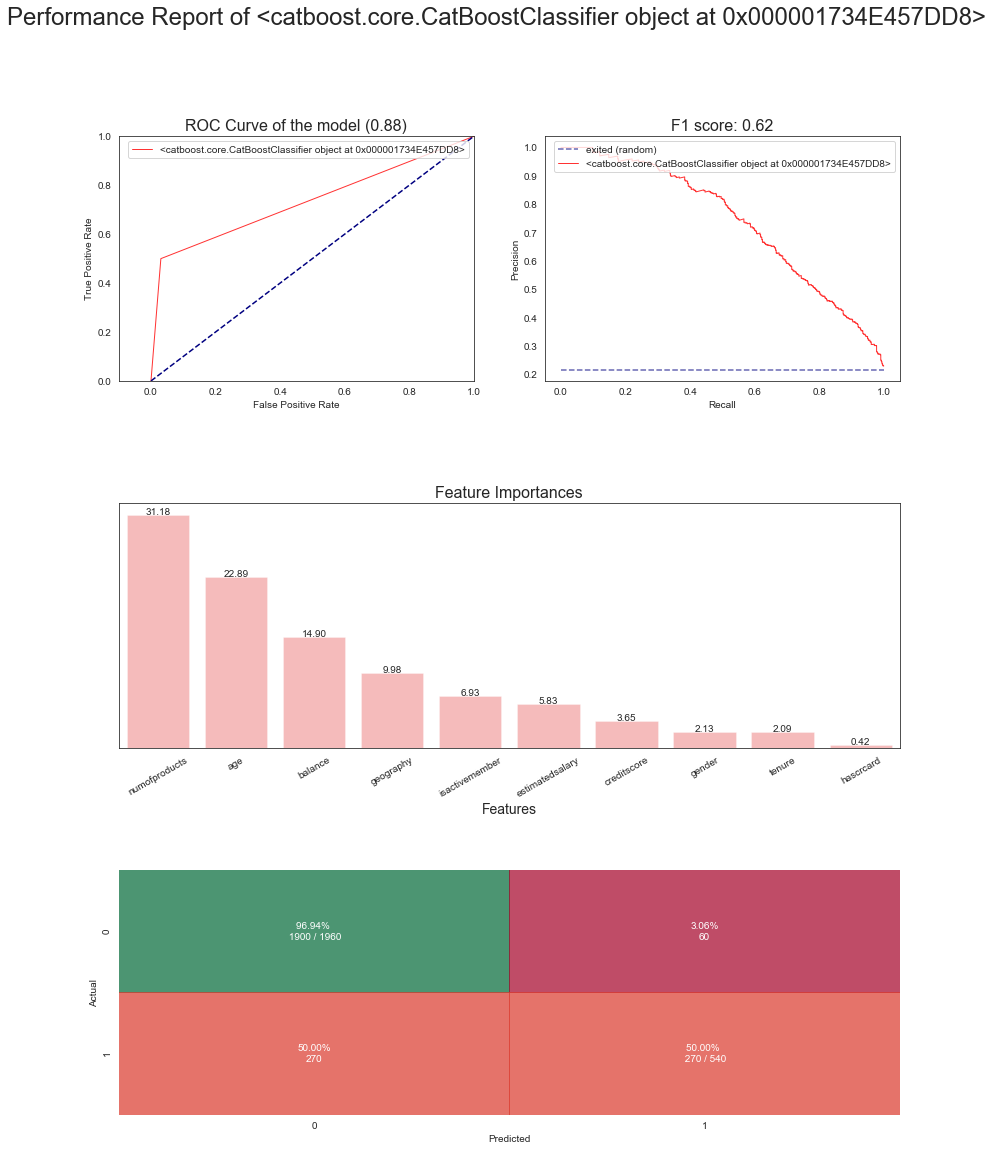

In [18]:
X_train, y_train, X_test, y_test = generate_train_test(df, test_size=.25)
cat_model = catboost.CatBoostClassifier(random_state=SEED, verbose=False)
cat_model.fit(X_train, y_train, cat_features=[1, 2])
y_pred = cat_model.predict(X_test)
y_prob = cat_model.predict_proba(X_test)
print_model_evaluation(model=cat_model, y_true=y_test, y_pred=y_pred, y_prob=y_prob)
plot_model_evaluation(cat_model, y_test, y_pred, y_prob, X_train)


Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      1960
           1       0.76      0.50      0.60       540

   micro avg       0.86      0.86      0.86      2500
   macro avg       0.82      0.73      0.76      2500
weighted avg       0.85      0.86      0.85      2500


Accuracy Score:  0.8572
F1 Score:  0.6002
Area Under Curve:  0.8718 



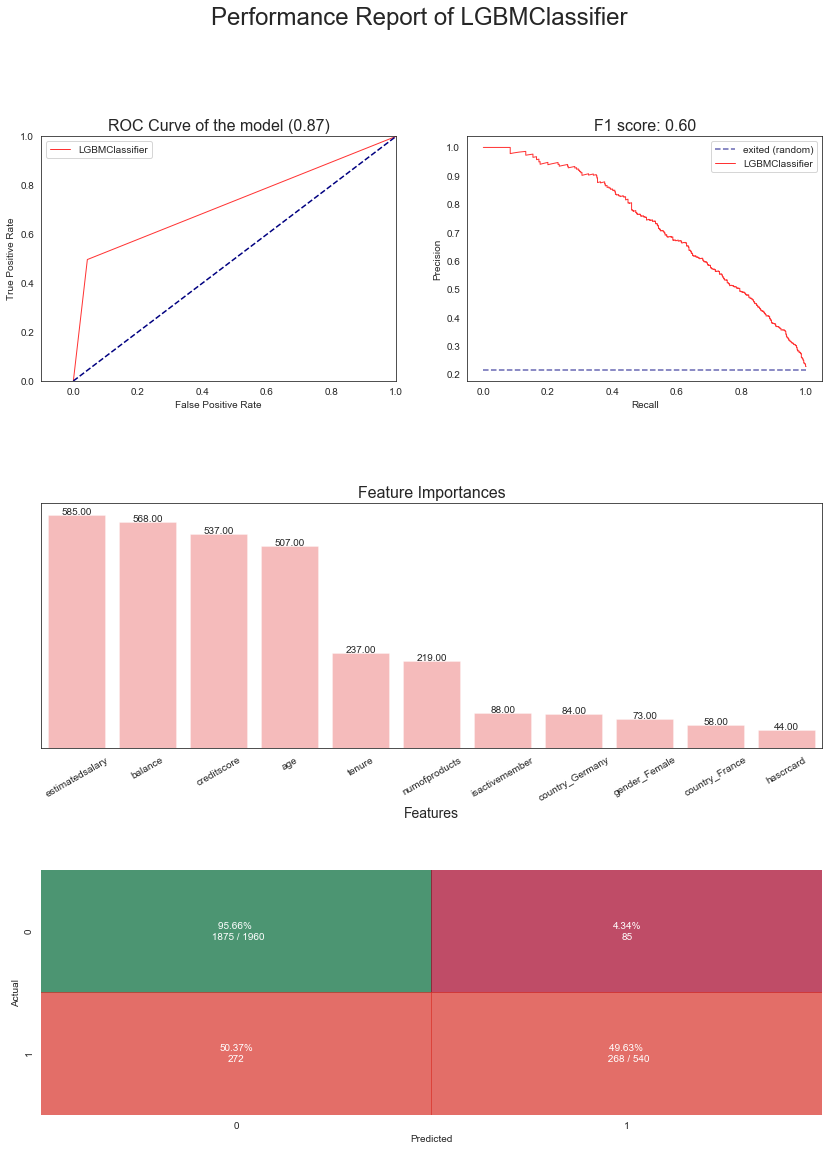

In [19]:
X_train, y_train, X_test, y_test = generate_train_test(transformed_df, test_size=.25)
lgb_model = lgb.LGBMClassifier(random_state=SEED)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
y_prob = lgb_model.predict_proba(X_test)
print_model_evaluation(model=lgb_model, y_true=y_test, y_pred=y_pred, y_prob=y_prob)
plot_model_evaluation(lgb_model, y_test, y_pred, y_prob, X_train)

## Model Interpretation

- We have built several tree-based model and show the performance of the model
- Normally, we will show the results with feature importances to the business users.
- However, the human-language explanation can be added for buy-in purpose.

In the above section, I have provided the feature importance plot along with each model algorithm. In short, feature importance plot shows the ranking and resulting values (__importance__).

<br>

However, when we use the resulting values, we need to understand what is the value represented. There are several calculation / types:

<br>

__1. Gain__: implies the relative contribution to the model calculated by using each feature's contribution for each tree in the model. The higher the value, more important of the feature for predicting the result.


__2. Coverage__: relative number of observations related to each feature (`feature x` used to decide the leaf node for `a`, `b`, and `c` observations; a+b+c), and expressed as a percentage for all features' cover metrics.

__3. Weight__: is the percentage representing the relative number of times the feature occurs in the trees of the model, and expressed as its percentage weight over weights of all features.

<br>

Generally, we will focus on `gain` of each feature.

For interpretation, there are 2 main classes: local and global.

1. Local interpretability: provide detailed explanations of how each individual prediction was made. This will help the users to trust our model and understand how the model / recommendations are being made.

2. Global interpretability: provide overall understanding of the structure of the model, how the model works in general. This is more important for senior or sponsors needing to understand the model at high level.




### eli5 

There are two main ways to look at a classification or a regression model:

1. inspect model parameters and try to figure out how the model works globally (`eli5.show_weights()`)
2. inspect an individual prediction of a model, try to figure out why the model makes the decision it makes (`eli5.show_prediction()`)


In [20]:
import eli5

eli5 can show the weight which is similar to LGB feature importance plot

In [21]:
eli5.show_weights(lgb_model)

One thing we can do with `eli5` is __permutation importance__ (or Mean Decrease Accuracy, MDA).

The idea is that the feature importance can be measured by looking at how much the score (which can be accuracy, f1, etc) decreases when a feature is not available. However, to avoid the re-training of the model, it does not remove the feature but replace it with random noise. This workds if noise is drawn from the same distribution as original feature values. The simplest way to get such noise is to shuffle values for a feature (i.e. use other examples' feature values). 

It can be resource-intensive if the number of columns are huge.

To summarize, the process of permutation is as follows:

1. Get a trained model or estimator
2. Shuffle the values in a single column, make the prediction using the resulting dataset. Use these predictions and the true target values to calculate how much loss function suffered from shuffling. The performance deterioration measures the importance of the feature you just shuffled
3. Return the data to the original order. Repeat step 2 on the next feature

<hr><br>


To __interpret the permutation importances__, the values toward the top are the most important features, and those toward the bottom matter least.

The output weight are in the following form `x±y`, the first number shows how much model performance decreased with a random shuffling. The ± sign shows some randomness to the exact performance change from a shuffling on the feature. This randomness is measured by repeating the shuffling process.

Occasionally, the permutation importance will give the negative results. Hences, the predictions on the shuffled data are eventually more accurate than the real data. This happends when the feature(s) didn't matter (the actual importance is close to 0) and random chance caused the predictions on the shuffled data to be more accurate.


But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

- a large effect for a few predictions, but no effect in general, or
- a medium effect for all predictions.

In [22]:
perm = eli5.sklearn.PermutationImportance(lgb_model, random_state=SEED).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

In [23]:
perm = eli5.sklearn.PermutationImportance(lgb_model, random_state=SEED).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

eli5 can also do the local explanation, that is explained the individual prediction of the black box model. It explains each predictions by showing feature weights, which are calculated by following decision paths of each tree in the ensemble. Each leaf has an output score, and expected scores can also be assigned to parent nodes. Contribution of each feature on the decision path is how much expected score changes from parent to child. Weights of all features sum to the output score of the model.


Below are the example.

In [24]:
eli5.explain_prediction_lightgbm(lgb_model, X_test.iloc[1])

Explanation(estimator="LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n        importance_type='split', learning_rate=0.1, max_depth=-1,\n        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,\n        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,\n        random_state=4895, reg_alpha=0.0, reg_lambda=0.0, silent=True,\n        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=2.0944984423229904, std=None, value=1.0), FeatureWeight(feature='age', weight=0.6738958728296114, std=None, value=30.0), FeatureWeight(feature='estimatedsalary', weight=0.6059547143386692, std=None, value=1852.58), FeatureWeight(feature='balance', weight=0.437158587465734, std=None, value=105209.54), FeatureWeight(feature='country_France', weight=0.2523880127910441, std=None, value=1.0), FeatureWeight(feature='country_Germany', weight=0.20873779870612028, std=None, value=0.0), FeatureWeight(feature='creditscore', weight=0.1556133710170295, std=None, value=740.0), FeatureWeight(feature='tenure', weight=0.13047353509823556, std=None, value=8.0)], neg=[FeatureWeight(feature='numofproducts', weight=-0.4798478884532119, std=None, value=1.0), FeatureWeight(feature='gender_Female', weight=-0.3432590311116296, std=None, value=1.0), FeatureWeight(feature='isactivemember', weight=-0.21259439581358194, std=None, value=0.0), FeatureWeight(feature='hascrcard', weight=-0.009729142803797403, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.971063550234254, score=-3.513289876387213, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [25]:
eli5.explain_prediction_lightgbm(lgb_model, X_test.iloc[4])

Explanation(estimator="LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,\n        importance_type='split', learning_rate=0.1, max_depth=-1,\n        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,\n        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,\n        random_state=4895, reg_alpha=0.0, reg_lambda=0.0, silent=True,\n        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='age', weight=3.3886952443576965, std=None, value=61.0), FeatureWeight(feature='isactivemember', weight=0.8732459930488173, std=None, value=0.0), FeatureWeight(feature='estimatedsalary', weight=0.6094234520637428, std=None, value=31641.52), FeatureWeight(feature='numofproducts', weight=0.36442209109815704, std=None, value=1.0), FeatureWeight(feature='balance', weight=0.15886054816347686, std=None, value=0.0), FeatureWeight(feature='creditscore', weight=0.0683740672428935, std=None, value=620.0), FeatureWeight(feature='hascrcard', weight=0.044554683423822426, std=None, value=0.0), FeatureWeight(feature='tenure', weight=0.017500072020643916, std=None, value=5.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-2.0944984423229904, std=None, value=1.0), FeatureWeight(feature='gender_Female', weight=-0.11726178930992322, std=None, value=0.0), FeatureWeight(feature='country_France', weight=-0.029666794372574662, std=None, value=1.0), FeatureWeight(feature='country_Germany', weight=-0.022438064548122093, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.9630738833120672, score=3.2612110608656404, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

### Partial Dependence Plots¶

- PDP can show whether the relationship between target and a feature is linear, monotonic or more complex.
- The partial function tells us for given value(s) of features what the average marginal effect on the prediction is
- For calssification where the machine learning model outputs probabilities, the PDP displays the probability for a certain class given different values for feature
- The partial dependence plot is a __global method__: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

<hr>

The goal is to visualize the impact of certain features towards model prediction for any supervised learning algorithm using partial dependence plots.

- Feature importance shows what variables most affect the predictions
- Partial dependence plots show how a feature affects the predictions


<hr>

This is very useful and can provide additional insights to the questions like;
- How would similar sized houses be priced in different areas?
- Are the predicted outcome difference between two groups / segments due to differences in specific features?

In [26]:
from pdpbox import pdp, get_dataset, info_plots

__Target plots__

Plot average target values across the different feature values (feature grids)

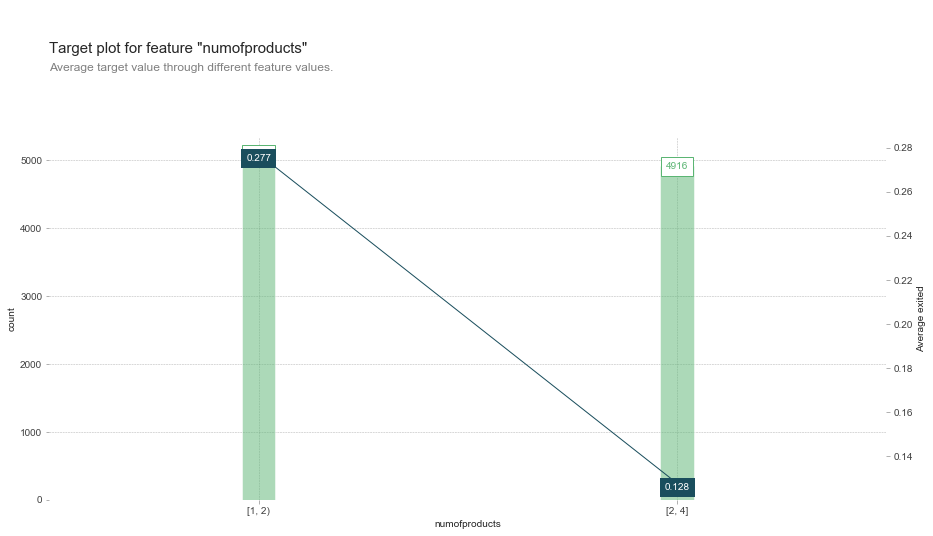

In [27]:
fig, axes, _smry_df = info_plots.target_plot(df=transformed_df, 
                                             feature="numofproducts", 
                                             feature_name="numofproducts",
                                            target="exited")

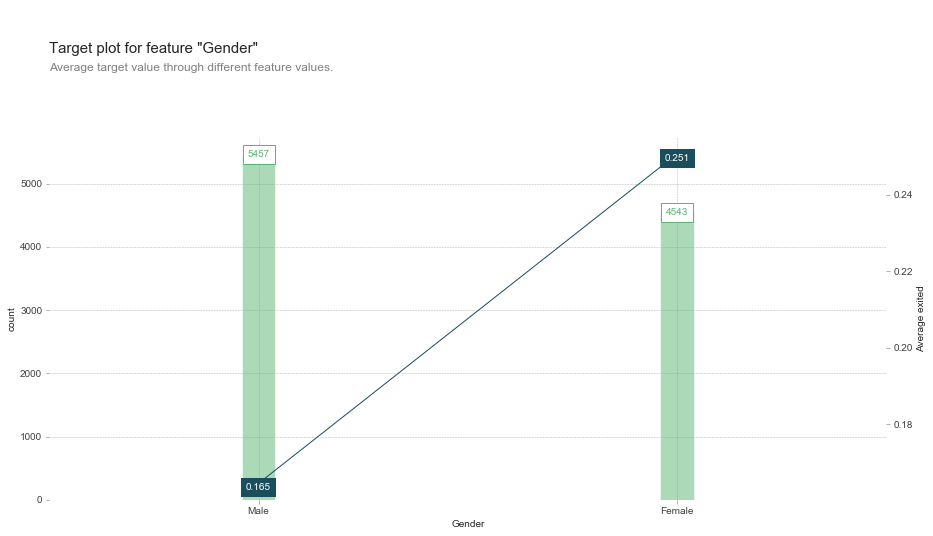

In [28]:
fig, axes, _smry_df = info_plots.target_plot(df=transformed_df, 
                                             feature="gender_Female", 
                                             feature_name="Gender",
                                            target="exited")
_ = axes['bar_ax'].set_xticklabels(["Male", "Female"])

Check the prediction distribution through feature

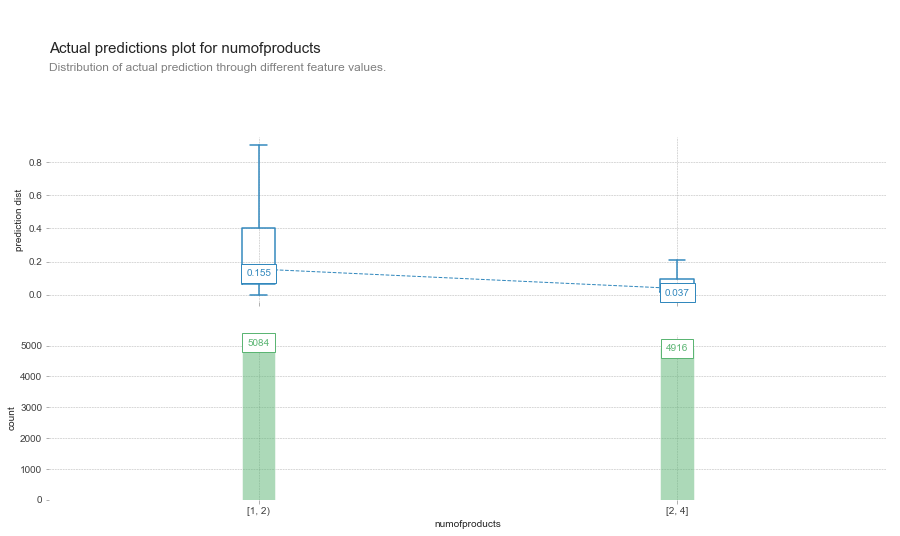

In [29]:
fig, axes, _smry_df = info_plots.actual_plot(model=lgb_model, X=transformed_df[X_train.columns], feature="numofproducts",
                                             feature_name="numofproducts", predict_kwds={})

Now let's see the PDP for top features.

- The pdp function at a particular feature value represents the average prediction if we force all data points to assume that feature value.

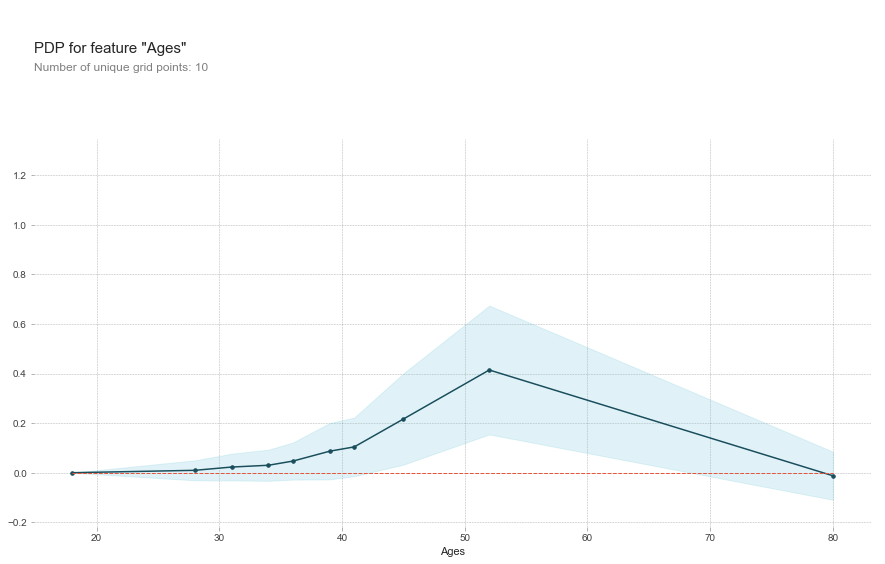

In [30]:
pdp_goals = pdp.pdp_isolate(model=lgb_model, dataset=X_test, 
                            model_features=X_test.columns, feature='age')
pdp.pdp_plot(pdp_goals, 'Ages')
plt.show()

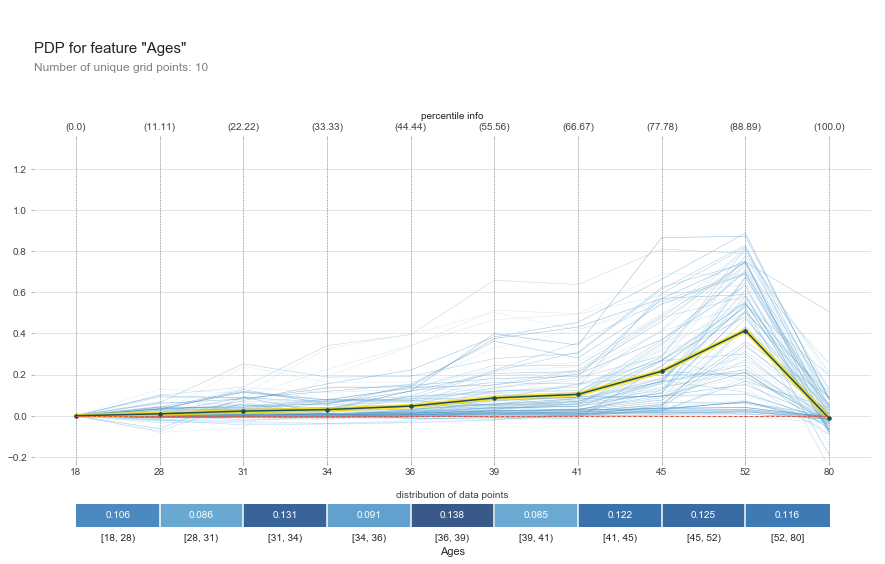

In [31]:
fig, axes = pdp.pdp_plot(pdp_goals, 'Ages', center=True, plot_lines=True,
                         x_quantile=True, show_percentile=True,
                         frac_to_plot=100, plot_pts_dist=True)
plt.show()

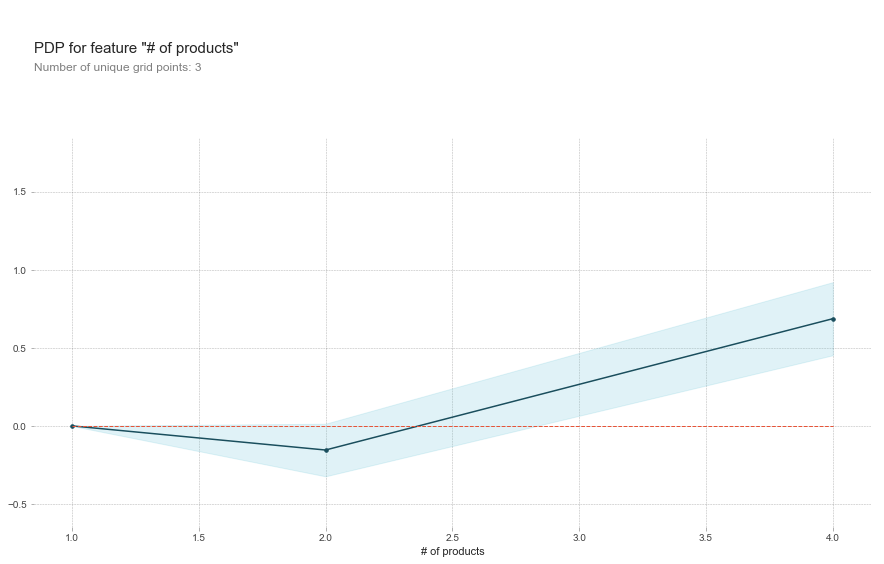

In [32]:
pdp_goals = pdp.pdp_isolate(model=lgb_model, dataset=X_test, 
                            model_features=X_test.columns, feature='numofproducts')
pdp.pdp_plot(pdp_goals, '# of products')
plt.show()

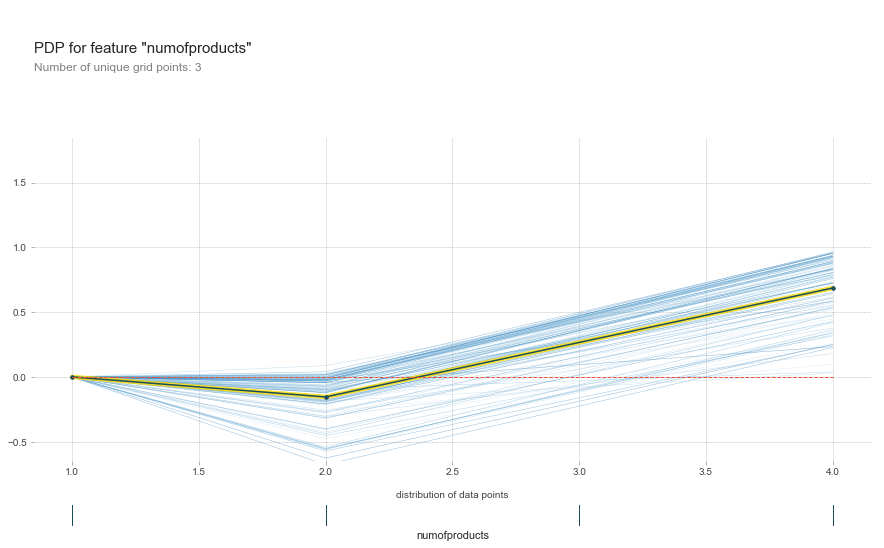

In [33]:
fig, axes = pdp.pdp_plot(pdp_goals, 'numofproducts', center=True, plot_lines=True, frac_to_plot=100, plot_pts_dist=True)

__2D Partial Dependence Plots__

If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify this.

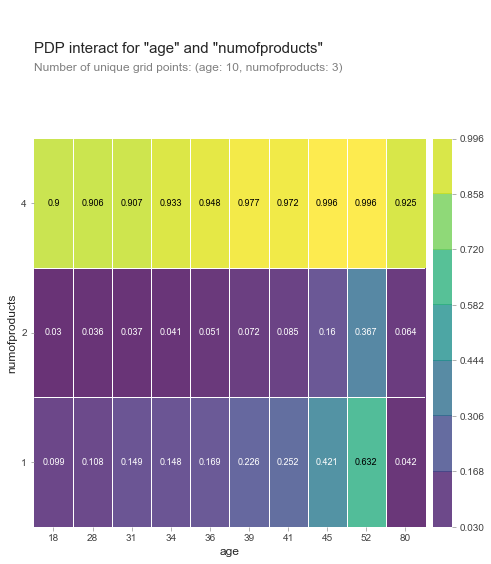

In [34]:
inter1  =  pdp.pdp_interact(model=lgb_model, 
                            dataset=X_test, model_features=X_test.columns, 
                            features=['age', 'numofproducts'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['age', 'numofproducts'], 
                      plot_type='grid', x_quantile=True, plot_pdp=False)

plt.show()


__Disadvantage__:
The assumption of independence is the biggest issue with PD plots. It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features.

### SHAP (SHapley Additive exPlanations)

- SHAP is based on the game theoretically optimal Shapley Values => tells us how to fairly distribute the payout among the features
- Shapley value is the __average marginal contribution__ of a feature value across all possible coalitions.
- The difference between the prediction and the average prediction is __fairly distributed__ among the feature values of the instance
- Shapley value allows __contrastive explanations__
- Shapley value is the only explanation method with a __solid theory__. Methods like LIME assume linear behavior of the machine learning model locally.
- The technical definition of a Shapley value is the “average marginal contribution of a feature value over all possible coalitions.” In other words, Shapley values consider all possible predictions for an instance using all possible combinations of inputs. Because of this exhaustive approach, SHAP can guarantee properties like consistency and local accuracy.
<br>

__Several Disadvantages__

- It can be misinterpreted, it is not the difference of the predicted value after removing the feature from the model training. The interpretation of the Shapley value is: Given the current set of feature values, the contribution of a feature value to the difference between the actual prediction and the mean prediction is the estimated Shapley value
- Shapley values always use all the features.
- Shapley value returns a simple value per feature, but no prediction model like LIME

In [35]:
explainer = shap.TreeExplainer(lgb_model)
X_train, y_train, X_test, y_test = generate_train_test(transformed_df, test_size=.25)
shap_values = explainer.shap_values(X_test)  # compute the Shapley values

Features with large absolute Shapley values are important (global importance). Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.

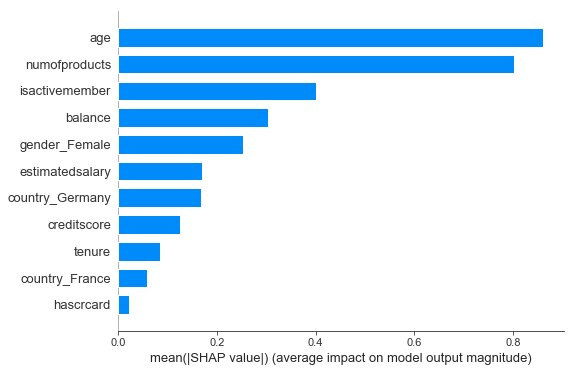

In [36]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

__SHAP Summary Plot__

- The plot combines feature importance with feature effects. Each point on the summary plot is a `Shapley` value for a feature and an instance.
- The color represents the value of the feature from low to high, x-axis is the Shapley value. 
- The features are ordered according to their importance

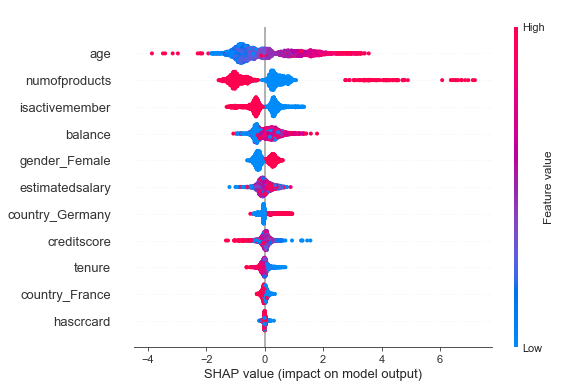

In [37]:
shap.summary_plot(shap_values, X_test)

__SHAP Dependence Plot__

- How a single feature effects the output of the model
- SHAP `dependece_plot` will automatically selects another feature for coloring
- This plot is the alternative to PDP and accumulated local effects (ALE)

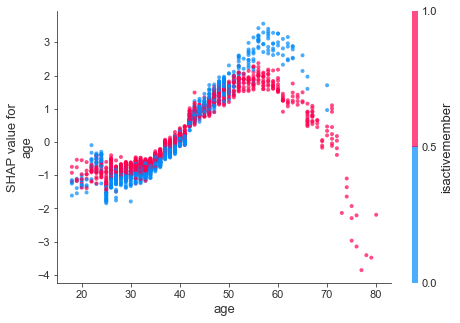

In [38]:
shap.dependence_plot("age", shap_values, X_test, interaction_index='auto', alpha=.7)

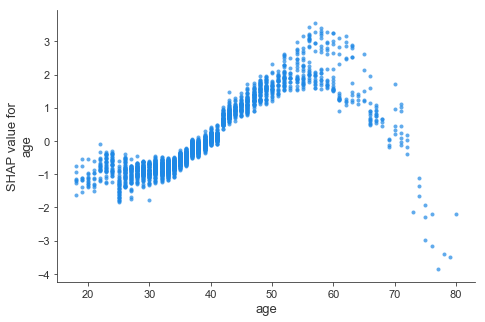

In [39]:
shap.dependence_plot("age", shap_values, X_test, 
                     interaction_index=None, alpha=.7)

Or we can turn the color off by using `interaction_index=None`

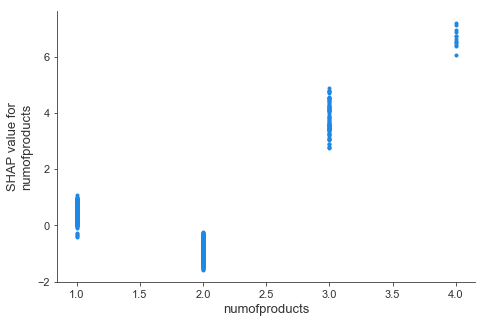

In [40]:
shap.dependence_plot("numofproducts", shap_values, X_test, interaction_index=None)

__Local interpretation__

- We can use `force_plot` to demonstrate how each SHAP value influences each individual prediction
- the baseline for Shapley value is the average of all predictions

In [41]:
shap.force_plot(explainer.expected_value, shap_values[1], X_test.iloc[[1]])

### LIME (Local interpretable model-agnostic explanations)

- LIME (Local Interpretable Model-agnostic Explanations) builds sparse linear models around each prediction to explain how the black box model works in that local vicinity. 
- Surrogate models are trained to approximate the predictions of the underlying black box model. Instead of training a global surrogate model, LIME focuses on training local surrogate models to explain __individual predictions__.
- LIME generates an explanation by approximating the underlying model by an interpretable one, learned on perturbations of the original instance.
- LIME is one of the few methods that works for tabular data, text and images.
- The __fidelity measure__ (how well the interpretable model approximates the black box predictions) gives us a good idea of how reliable the interpretable model is in explaining the black box predictions in the neighborhood of the data instance of interest.


We train the interpretation model by using command below:

In [42]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                        feature_names=X_train.columns.values.tolist(),
                                                        class_names=['non_exited', 'exited'],
                                                        verbose=True,
                                                        mode='classification'
                                                       )

In [43]:
print(lgb_model.predict_proba(X_test.iloc[[1, 2, 46]]))
print(y_test.iloc[[1, 2, 46]])

[[0.97106355 0.02893645]
 [0.94824325 0.05175675]
 [0.01999862 0.98000138]]
3072    0
2756    0
2124    1
Name: exited, dtype: int64


___Remark ::___ 

`exp.as_map() * scaled instance + exp.intercept`

In [44]:
expLgb = lime_explainer.explain_instance(data_row=X_test.values[1], predict_fn=lgb_model.predict_proba, 
                                         num_features=11)
expLgb.show_in_notebook(show_table=True)

Intercept 0.1540605665558875
Prediction_local [0.21644147]
Right: 0.02893644976574609


In [45]:
expLgb.as_list()

[('age <= 32.00', -0.17372766361879116),
 ('isactivemember <= 0.00', 0.13792353507795332),
 ('numofproducts <= 1.00', 0.07880667093109449),
 ('0.00 < gender_Female <= 1.00', 0.050291303132366114),
 ('country_Germany <= 0.00', -0.03242991231795554),
 ('96908.79 < balance <= 127591.88', 0.022313787405728865),
 ('0.00 < country_France <= 1.00', -0.013563016867793397),
 ('tenure > 7.00', -0.013184455473484836),
 ('creditscore > 717.00', -0.012807617348590754),
 ('estimatedsalary <= 52138.30', 0.009911352545063711),
 ('0.00 < hascrcard <= 1.00', 0.008846918813526929)]

In [46]:
expLgb = lime_explainer.explain_instance(X_test.values[2], lgb_model.predict_proba, num_features=5)
expLgb.show_in_notebook(show_table=True)

Intercept 0.31498415729467205
Prediction_local [0.06595949]
Right: 0.051756746350033515


In [47]:
expLgb = lime_explainer.explain_instance(X_test.values[46], lgb_model.predict_proba, num_features=5)
expLgb.show_in_notebook(show_table=True)

Intercept 0.18944361823166944
Prediction_local [0.67222602]
Right: 0.980001376919773
